# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from train_test.load_train import *
from train_test.load_test import *

In [3]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

import seaborn as sns

In [85]:
from dataloaders import dataset_CPoint_Sparse
# from dataloaders import load_dataset
# from loss import losses_SparseData
# from models import models_SparseData
# from optimizer import load_optimizer

from subprocess import Popen

# Load dictionary

In [161]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/CPoint_Sparse/CPoint_Sparse_Transformer_0.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_Transformer', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'CPoint_Sparse', 'piezo_head': True, 'relative_target': False, 'target_lags': [1, 2], 'nan_treshold': 10, 'fill_value': 0, 'normal

# Dataset class

In [164]:
importlib.reload(dataset_CPoint_Sparse)

<module 'dataloaders.dataset_CPoint_Sparse' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_CPoint_Sparse.py'>

In [165]:
ds = dataset_CPoint_Sparse.Dataset_CPoint_Sparse(dict_files)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_means': np.float64(298.19569411165224), 'target_stds': np.float64(73.65282819016454), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.602
    tmax         float32 4B 12.35
    tmin         float32 4B 5.037
    tmean        float32 4B 8.694, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    s

In [166]:
ds.wtd_df

wtd       lat       lon    height         h  \
date       sensor_id                                                        
2000-12-31 00103510001        NaN  0.053733 -0.154105 -0.866947       NaN   
           00104110001        NaN  0.202696  0.094087 -0.951262       NaN   
           00105110001        NaN  0.446357  0.518426 -1.021212       NaN   
           00105910001        NaN  0.149836  0.808310 -1.018794       NaN   
           00105910002        NaN  0.233721  0.722698 -1.028230       NaN   
...                           ...       ...       ...       ...       ...   
2023-12-24 00417910001   5.068571 -0.123456  0.725215 -0.997253 -0.626484   
           00421510001   3.931905 -0.516018  0.642913 -0.929923  0.197800   
           00421710001   6.553762 -0.380864  0.446580 -0.962027 -0.223473   
           00422510001  26.085667 -0.911923  0.364473 -0.777247  1.731121   
           00425010001   4.953333 -0.751001  0.463569 -0.852743  1.111101   

                             doy_sin   doy_cos  
date       sensor_id                            
2000-12-31 00103510001 -2.449294e-16  1.000000  
           00104110001 -2.449294e-16  1.000000  
           00105110001 -2.449294e-16  1.000000  
           00105910001 -2.449294e-16  1.000000  
           00105910002 -2.449294e-16  1.000000  
...                              ...       ...  
2023-12-24 00417910001 -1.369061e-01  0.990584  
           00421510001 -1.369061e-01  0.990584  
           00421710001 -1.369061e-01  0.990584  
           00422510001 -1.369061e-01  0.990584  
           00425010001 -1.369061e-01  0.990584  

[33600 rows x 7 columns]

In [167]:
ds.lagged_df

h       lat       lon    height   doy_sin  \
date       sensor_id                                                       
2001-03-04 00103510001  0.689230  0.053733 -0.154105 -0.866947  0.882679   
           00104110001       NaN  0.202696  0.094087 -0.951262  0.882679   
           00105110001       NaN  0.446357  0.518426 -1.021212  0.882679   
           00105910001 -0.898284  0.149836  0.808310 -1.018794  0.882679   
           00105910002       NaN  0.233721  0.722698 -1.028230  0.882679   
...                          ...       ...       ...       ...       ...   
2023-12-24 00417910001 -0.626484 -0.123456  0.725215 -0.997253 -0.136906   
           00421510001  0.197800 -0.516018  0.642913 -0.929923 -0.136906   
           00421710001 -0.223473 -0.380864  0.446580 -0.962027 -0.136906   
           00422510001  1.731121 -0.911923  0.364473 -0.777247 -0.136906   
           00425010001  1.111101 -0.751001  0.463569 -0.852743 -0.136906   

                         doy_cos  doy_sin_lag1  doy_cos_lag1  \
date       sensor_id                                           
2001-03-04 00103510001  0.469977      0.819972      0.572404   
           00104110001  0.469977      0.819972      0.572404   
           00105110001  0.469977      0.819972      0.572404   
           00105910001  0.469977      0.819972      0.572404   
           00105910002  0.469977      0.819972      0.572404   
...                          ...           ...           ...   
2023-12-24 00417910001  0.990584     -0.254671      0.967028   
           00421510001  0.990584     -0.254671      0.967028   
           00421710001  0.990584     -0.254671      0.967028   
           00422510001  0.990584     -0.254671      0.967028   
           00425010001  0.990584     -0.254671      0.967028   

                        00103510001_lag1  00104110001_lag1  ...  \
date       sensor_id                                        ...   
2001-03-04 00103510001          0.691232               NaN  ...   
           00104110001          0.691232               NaN  ...   
           00105110001          0.691232               NaN  ...   
           00105910001          0.691232               NaN  ...   
           00105910002          0.691232               NaN  ...   
...                                  ...               ...  ...   
2023-12-24 00417910001          0.662022         -0.340009  ...   
           00421510001          0.662022         -0.340009  ...   
           00421710001          0.662022         -0.340009  ...   
           00422510001          0.662022         -0.340009  ...   
           00425010001          0.662022         -0.340009  ...   

                        00407810001_lag2  00408910001_lag2  00408910002_lag2  \
date       sensor_id                                                           
2001-03-04 00103510001          2.425338          0.723081               NaN   
           00104110001          2.425338          0.723081               NaN   
           00105110001          2.425338          0.723081               NaN   
           00105910001          2.425338          0.723081               NaN   
           00105910002          2.425338          0.723081               NaN   
...                                  ...               ...               ...   
2023-12-24 00417910001          2.399884               NaN          1.354466   
           00421510001          2.399884               NaN          1.354466   
           00421710001          2.399884               NaN          1.354466   
           00422510001          2.399884               NaN          1.354466   
           00425010001          2.399884               NaN          1.354466   

                        00414310002_lag2  00417910001_lag2  00421510001_lag2  \
date       sensor_id                                                           
2001-03-04 00103510001               NaN         -0.617409          0.201254   
           00104110001               NaN         -0.6174

In [169]:
(pd.Series(ds.dates).diff().dropna() == pd.Timedelta('1W')).all()

np.True_

In [ ]:
ds.lagged_df.loc[]

In [65]:
ds.weather_coords.shape

(9, 12, 3)

In [88]:
# X [values, coords, mask]
print(ds[-1][0][0].shape)
print(ds[-1][0][1].shape)
print(ds[-1][0][2].shape)

torch.Size([2, 28])
torch.Size([2, 28, 5])
torch.Size([2, 28])


In [10]:
print(ds[-1][2].shape)


torch.Size([28, 5])


In [11]:
print(ds[-1][1][0].shape)


torch.Size([4, 5, 9, 12])


In [90]:
ds[-1][0][1]

tensor([[[ 4.4830e+01,  7.3085e+00,  3.7242e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4878e+01,  7.4156e+00,  2.9782e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4957e+01,  7.5987e+00,  2.3592e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4861e+01,  7.7238e+00,  2.3806e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4888e+01,  7.6868e+00,  2.2971e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4787e+01,  7.3810e+00,  2.9751e+02, -2.5467e-01,  9.6703e-01],
         [ 4.5094e+01,  7.5747e+00,  2.9165e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4963e+01,  7.6731e+00,  2.2383e+02, -2.5467e-01,  9.6703e-01],
         [ 4.5016e+01,  7.5345e+00,  2.7229e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4925e+01,  7.8477e+00,  2.3871e+02, -2.5467e-01,  9.6703e-01],
         [ 4.4889e+01,  7.4948e+00,  2.5908e+02, -2.5467e-01,  9.6703e-01],
         [ 4.5051e+01,  7.6556e+00,  2.5004e+02, -2.5467e-01,  9.6703e-01],
         [ 4.5078e+01,  7.7187e+00,  2.1641e+02, -2.5467e-01,  9.6703e-01],
         [ 4

In [88]:
print(ds[-1][1][0].shape)
print(ds[-1][1][1].shape)

torch.Size([4, 5, 9, 12])
torch.Size([5, 5, 9, 12])


In [92]:
ds[-1][1][1][-1,:,:,:]

tensor([[[0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150,
          0.8150, 0.8150, 0.8150, 0.8150],
         [0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150, 0.8150

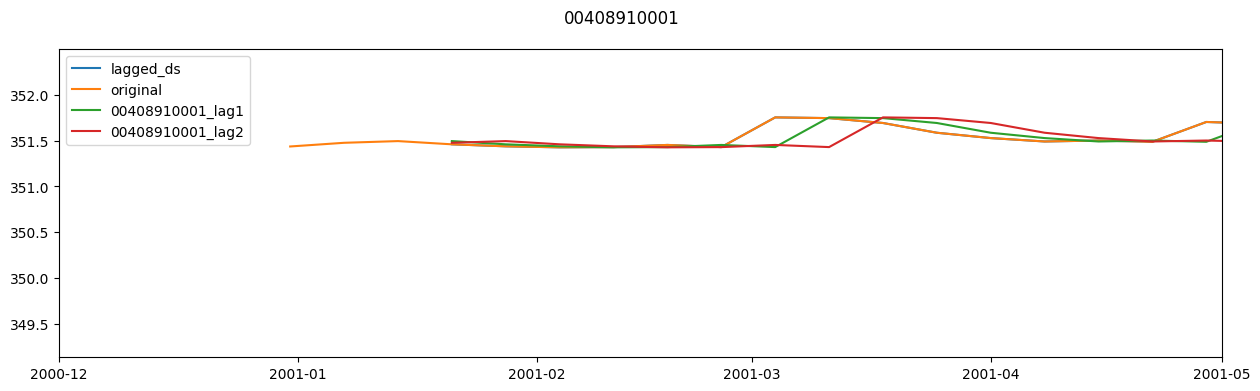

In [69]:
# Test
sensor = -8
fig, ax = plt.subplots(figsize = (15,4))
sensor_id = ds.sensor_id_list[sensor]
sensor_lag_names = [name for name in ds.lagged_df.columns if sensor_id in name]

fig.suptitle(sensor_id)

ax.plot(ds.lagged_df.loc[pd.IndexSlice[:,sensor_id],
                      ds.target].droplevel(1), label = "lagged_ds")

ax.plot(ds.wtd_df.loc[pd.IndexSlice[:,sensor_id],
                      ds.target].droplevel(1), label = "original")


for i in range(len(ds.target_lags)):
    
    ax.plot(ds.lagged_df.loc[pd.IndexSlice[:,sensor_id],
                      sensor_lag_names[i]].droplevel(1), label = sensor_lag_names[i])    
ax.legend()
ax.set_xlim(np.datetime64("2000-12-01"),
            np.datetime64("2001-05-01"))
    
plt.show()

<Axes: xlabel='wtd', ylabel='Count'>

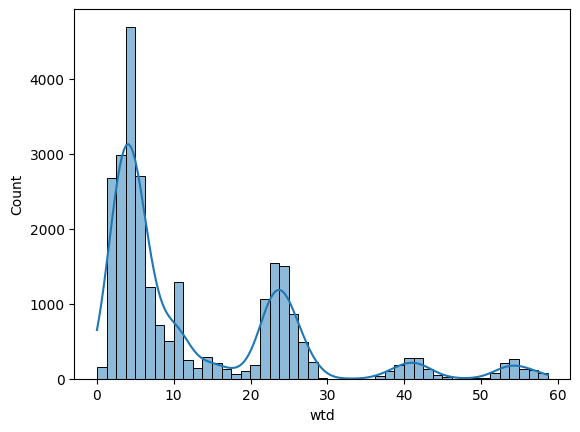

In [76]:
sns.histplot(ds.wtd_df["wtd"], kde=True)

<Axes: ylabel='Count'>

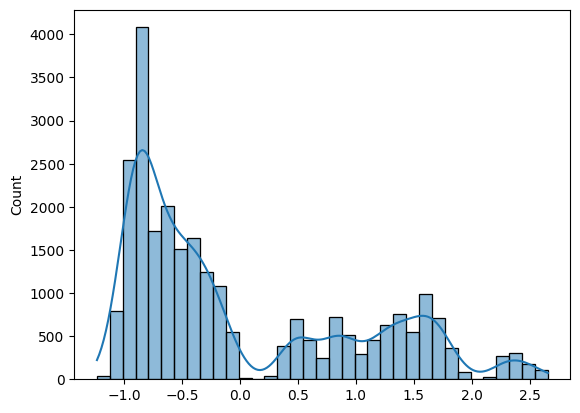

In [23]:
new_var = ds.wtd_df["wtd"]/ds.wtd_df["height"]
new_var_mean = new_var.mean()
new_var_std = new_var.std()
sns.histplot((new_var-new_var_mean)/new_var_std, kde=True)

<Axes: ylabel='Count'>

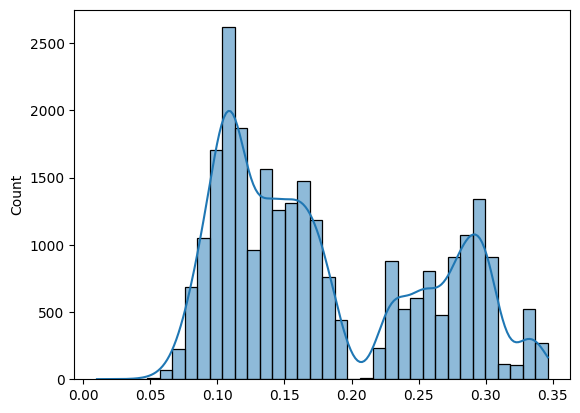

In [26]:
new_var = np.sqrt(ds.wtd_df["wtd"]/ds.wtd_df["height"])
new_var_mean = new_var.mean()
new_var_std = new_var.std()
#new_var = (new_var-new_var_mean)/new_var_std
sns.histplot(new_var, kde=True)

In [31]:
ds.weather_xr.time.dt.year - 2000

<xarray.DataArray 'year' (time: 3410)> Size: 27kB
array([-42, -42, -42, ...,  23,  23,  23])
Coordinates:
  * time         (time) datetime64[ns] 27kB 1958-08-24 1958-08-31 ... 2023-12-24
    spatial_ref  int64 8B 0

<Axes: ylabel='Count'>

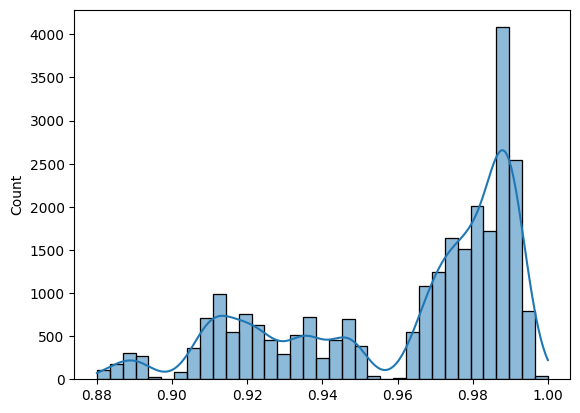

In [28]:
new_var = ds.wtd_df["h"]/ds.wtd_df["height"]
new_var_mean = new_var.mean()
new_var_std = new_var.std()
#new_var = (new_var-new_var_mean)/new_var_std
sns.histplot(new_var, kde=True)

<Axes: xlabel='h', ylabel='Count'>

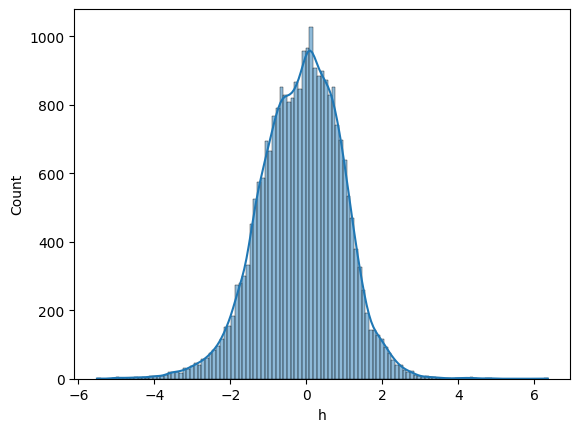

In [12]:
sns.histplot(ds.wtd_df["h"], kde=True)

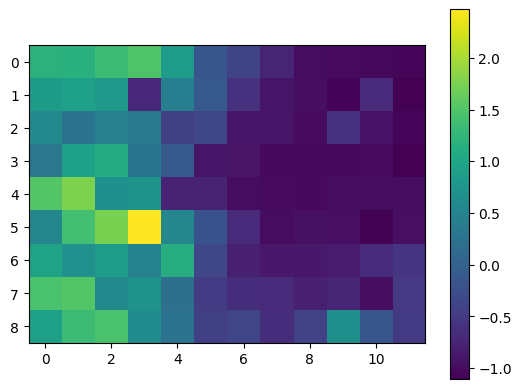

In [13]:
plt.imshow(ds[0][2][0][2,13,:,:])
plt.colorbar()
plt.show()

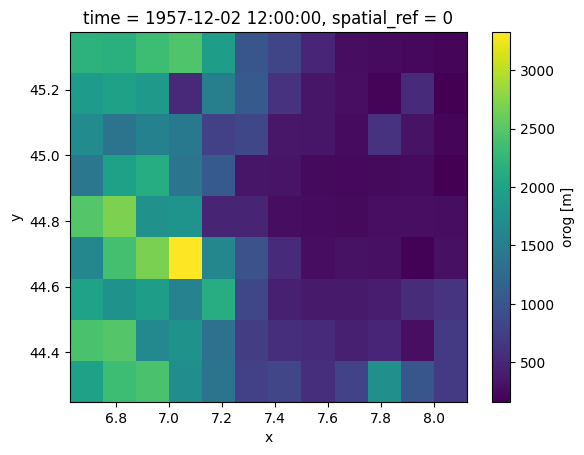

In [14]:
ds.weather_dtm.plot()

In [15]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

In [16]:
import geopy.distance

In [17]:
spatial_resolution_meteo =  geopy.distance.geodesic((ds.weather_xr.lat.values[4],
                               ds.weather_xr.lon.values[0]),
                               (ds.weather_xr.lat.values[5],
                                ds.weather_xr.lon.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_meteo, 5))

Y - Resolution in km:  13.89086


In [18]:
spatial_resolution_dtm =  geopy.distance.geodesic((ds.dtm_roi.y.values[4],
                               ds.dtm_roi.x.values[0]),
                               (ds.dtm_roi.y.values[5],
                                ds.dtm_roi.x.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_dtm, 5))

Y - Resolution in km:  0.09261


## Dataloader test

In [82]:
from dataloaders import load_dataset
importlib.reload(load_dataset)

train_loader, test_loader = load_dataset.get_dataloader(ds, dict_files)

Traing size: 882 - Start: 2001-01-21 - End: 2017-12-17;
Test size: 315 - Start: 2018-03-11 - End: 2023-12-24


# Model 

In [89]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/CPoint_Sparse/CPoint_Sparse_Transformer_0.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_Transformer', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'CPoint_Sparse', 'piezo_head': True, 'relative_target': False, 'target_lags': [1, 2], 'nan_treshold': 5, 'fill_value': 0, 'normali

In [93]:
from models import models_CPoint_Sparse
importlib.reload(models_CPoint_Sparse)
from models import load_model
importlib.reload(load_model)

<module 'models.load_model' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model.py'>

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [94]:
model, _ = load_model.load_model(dict_files)

Model: ST_MultiPoint_Net


In [95]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    
model = model.apply(weight_init)

In [96]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  34625


In [97]:
idx = 0
seq_len = 24
X_0 = []
X_1 = []
X_2 = []
W_0 = []
W_1 = []
Z = []
for i in range(seq_len):
    
    X_0.append(ds[i][0][0])
    X_1.append(ds[i][0][1])
    X_2.append(ds[i][0][2])
    W_0.append(ds[i][1][0])
    W_1.append(ds[i][1][1])
    Z.append(ds[i][2])
    
X = [torch.stack(X_0, dim = 0),
     torch.stack(X_1, dim = 0),
     torch.stack(X_2, dim = 0)]

W = [torch.stack(W_0, dim = 0),
     torch.stack(W_1, dim = 0)]

Z = torch.stack(Z, dim = 0)

In [139]:
from collections import deque
last_4_values = deque(maxlen=4)

In [152]:
last_4_values.append(4)

In [153]:
last_4_values

deque([1, 2, 3, 4], maxlen=4)

In [156]:
last_4_values[-4]

1

In [146]:
len(last_4_values)

2

In [98]:
model.train()
prova_out = model(X, W, Z)

In [168]:
(pd.Series(ds.dates).diff().dropna() == pd.Timedelta('1W')).all()

np.True_

In [160]:
ds.lagged_df

h        lat       lon      height   doy_sin  \
date       sensor_id                                                            
2001-01-21 00103510001         NaN  44.829842  7.308503  372.416901  0.352752   
           00104110001         NaN  44.877920  7.415599  297.815430  0.352752   
           00105110001         NaN  44.956561  7.598704  235.923615  0.352752   
           00105910001  232.139789  44.860859  7.723791  238.062408  0.352752   
           00105910002         NaN  44.887933  7.686849  229.713989  0.352752   
...                            ...        ...       ...         ...       ...   
2023-12-24 00417910001  252.053407  44.772655  7.687935  257.121979 -0.136906   
           00421510001  312.764201  44.645956  7.652421  316.696106 -0.136906   
           00421710001  281.736247  44.689577  7.567702  288.290009 -0.136906   
           00422510001  425.697628  44.518178  7.532273  451.783295 -0.136906   
           00425010001  380.031438  44.570116  7.575033  384.984772 -0.136906   

                         doy_cos  doy_sin_lag1  doy_cos_lag1  \
date       sensor_id                                           
2001-01-21 00103510001  0.935717      0.238033      0.971257   
           00104110001  0.935717      0.238033      0.971257   
           00105110001  0.935717      0.238033      0.971257   
           00105910001  0.935717      0.238033      0.971257   
           00105910002  0.935717      0.238033      0.971257   
...                          ...           ...           ...   
2023-12-24 00417910001  0.990584     -0.254671      0.967028   
           00421510001  0.990584     -0.254671      0.967028   
           00421710001  0.990584     -0.254671      0.967028   
           00422510001  0.990584     -0.254671      0.967028   
           00425010001  0.990584     -0.254671      0.967028   

                        00103510001_lag1  00104110001_lag1  ...  \
date       sensor_id                                        ...   
2001-01-21 00103510001               NaN               NaN  ...   
           00104110001               NaN               NaN  ...   
           00105110001               NaN               NaN  ...   
           00105910001               NaN               NaN  ...   
           00105910002               NaN               NaN  ...   
...                                  ...               ...  ...   
2023-12-24 00417910001        346.955472        273.153049  ...   
           00421510001        346.955472        273.153049  ...   
           00421710001        346.955472        273.153049  ...   
           00422510001        346.955472        273.153049  ...   
           00425010001        346.955472        273.153049  ...   

                        00407810001_lag2  00408910001_lag2  00408910002_lag2  \
date       sensor_id                                                           
2001-01-21 00103510001        477.559431        351.475976               NaN   
           00104110001        477.559431        351.475976               NaN   
           00105110001        477.559431        351.475976               NaN   
           00105910001        477.559431        351.475976               NaN   
           00105910002        477.559431        351.475976               NaN   
...                                  ...               ...               ...   
2023-12-24 00417910001        474.953955               NaN        397.955944   
           00421510001        474.953955               NaN        397.955944   
           00421710001        474.953955               NaN        397.955944   
           00422510001        474.953955               NaN        397.955944   
           00425010001        474.953955               NaN        397.955944   

                        00414310002_lag2  00417910001_lag2  00421510001_lag2  \
date       sensor_id                                                           
2001-01-21 00103510001               NaN        253.012812               

In [ ]:
ds.lagged_df[df.isna().all(axis=1)]

In [158]:
ds.dates

DatetimeIndex(['2001-01-21', '2001-01-28', '2001-02-04', '2001-02-11',
               '2001-02-18', '2001-02-25', '2001-03-04', '2001-03-11',
               '2001-03-18', '2001-03-25',
               ...
               '2023-10-22', '2023-10-29', '2023-11-05', '2023-11-12',
               '2023-11-19', '2023-11-26', '2023-12-03', '2023-12-10',
               '2023-12-17', '2023-12-24'],
              dtype='datetime64[ns]', name='date', length=1197, freq=None)

In [147]:
ds[0][0][0].shape

torch.Size([2, 28])

In [99]:
prova_out.shape

torch.Size([24, 28])

In [101]:
ds[0][-1][0]

tensor([     nan,      nan,      nan, 232.1398,      nan,      nan,      nan,
        219.2112,      nan,      nan, 257.8318, 226.8053,      nan,      nan,
             nan,      nan,      nan,      nan, 283.1330, 477.4004, 351.4593,
             nan,      nan, 252.9263,      nan,      nan, 428.8430,      nan])

In [100]:
ds[0][-1][1]

tensor([ True,  True,  True, False,  True,  True,  True, False,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True, False,  True,  True, False,  True])

In [103]:
ds[0][0][0]

tensor([[  0.0000,   0.0000,   0.0000, 232.1588,   0.0000,   0.0000,   0.0000,
         219.2498,   0.0000,   0.0000, 257.8613,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000, 283.1330, 477.4842, 351.4945,
           0.0000,   0.0000, 252.9946,   0.0000,   0.0000, 428.8785,   0.0000],
        [  0.0000,   0.0000,   0.0000, 232.1482,   0.0000,   0.0000,   0.0000,
         219.2951,   0.0000,   0.0000, 257.8576,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000, 283.1330, 477.5594, 351.4760,
           0.0000,   0.0000, 253.0128,   0.0000,   0.0000, 428.9054,   0.0000]])

In [102]:
ds[0][0][-1]

tensor([[ True,  True,  True, False,  True,  True,  True, False,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True, False, False,
         False,  True,  True, False,  True,  True, False,  True],
        [ True,  True,  True, False,  True,  True,  True, False,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True, False, False,
         False,  True,  True, False,  True,  True, False,  True]])

In [105]:
prova_out

tensor([[359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131,
         359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131,
         359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131,
         359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131, 359.5131],
        [359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618,
         359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618,
         359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618,
         359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618, 359.0618],
        [358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742,
         358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742,
         358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742,
         358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742, 358.9742],
        [357.8202, 357.8202, 357.8202, 357.8202, 

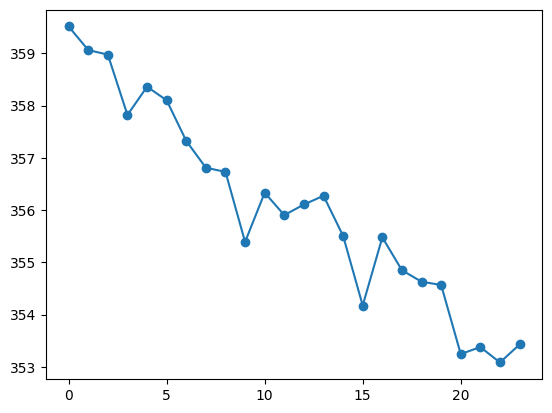

In [109]:
sensor = 0
plt.plot(prova_out[:,sensor].detach().cpu(), marker = "o")

In [113]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

## Grid prediction

In [116]:
ds[0][2].shape

torch.Size([28, 5])

In [114]:
lat_points = 42
lon_points = 62
z_grid = plot.grid_generation(ds, lat_points,lon_points)

In [126]:
#np.datetime64("2024-01-01").dt.dayofyear
pd.DatetimeIndex(["2024-01-01", "2024-01-01"]).day.values

array([1, 1], dtype=int32)

In [134]:
ds.temporal_encoding(mode = "sin", dates = pd.DatetimeIndex([np.datetime64("2024-01-01")]))

([array([0.01716633]), array([0.99985265])], ['doy_sin', 'doy_cos'])

In [115]:
z_grid.shape

(2604, 3)

In [37]:
date = "2020-01-05"
twindow = 3
lat_points = 42
lon_points = 62
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


In [45]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)

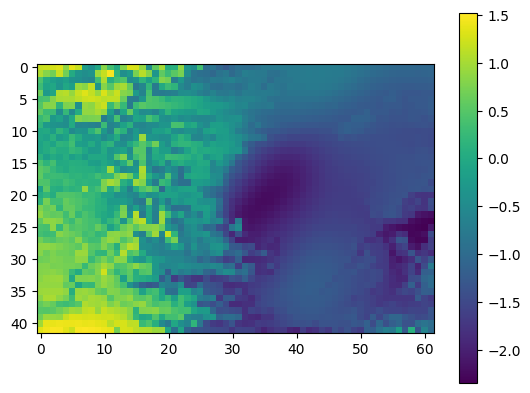

In [39]:
plt.imshow(Y_hat_test_grid[2,:,:])
plt.colorbar()

In [51]:
ds.target_means_xr.values[2,0]

np.float64(348.4555868937711)

In [55]:
(Y_hat_test_grid[:,0,0] * ds.target_stds_xr.values[0,0]) + ds.target_means_xr.values[0,0]

tensor([348.2361, 349.0766, 349.1225])

In [58]:
Y_hat_test_grid_denorm = (Y_hat_test_grid * ds.target_stds_xr.values) + ds.target_means_xr.values

/scratch_local/ipykernel_3959423/1791136785.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Y_hat_test_grid_denorm = (Y_hat_test_grid * ds.target_stds_xr.values) + ds.target_means_xr.values


/scratch_local/ipykernel_3959423/1525610506.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(Y_hat_test_grid_denorm[2,:,:]))


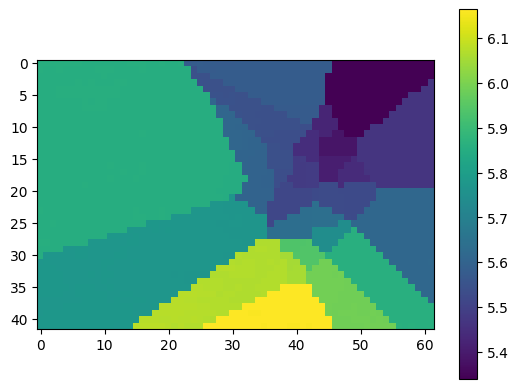

In [61]:
plt.imshow(np.log(Y_hat_test_grid_denorm[2,:,:]))
plt.colorbar()

In [49]:
Y_hat_xr = xarray.DataArray(data = Y_hat_test_grid,
                                coords = dict(
                                            lat=("lat", ((coords[:,0,0] * ds.norm_factors["lat_std"]) + ds.norm_factors["lat_mean"])),
                                            lon=("lon", ((coords[0,:,1] * ds.norm_factors["lon_std"]) + ds.norm_factors["lon_mean"])),
                                            time=pd.date_range(np.datetime64(date),
                                                            np.datetime64(date) + np.timedelta64(twindow-1, dict_files["frequency"]),
                                                            freq = dict_files["frequency"])),
                                dims = ["time","lat", "lon"]
                                )

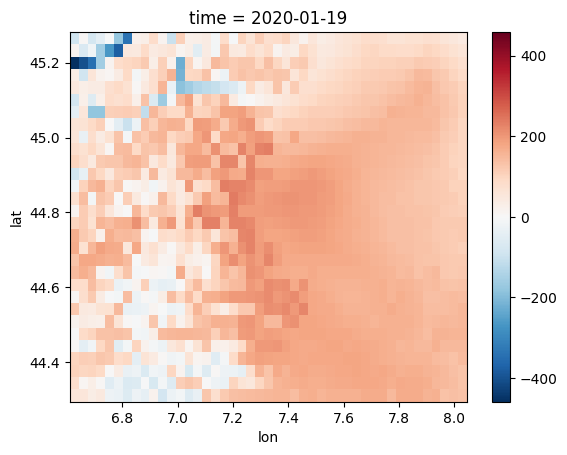

In [52]:
Y_hat_xr[2].plot()

## Load trained model

In [59]:
model_name_path = "model_SparseData_Transformer_20250717_171819" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

SparseData_Transformer(
  (activation_fn): LeakyReLU(negative_slope=0.01)
  (SparseAutoreg_Module): Spatial_Attention_Block(
    (activation): LeakyReLU(negative_slope=0.01)
    (topo_embeddings): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (value_embeddings): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (cb_multihead_att_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (norm_linear): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (ST_Conditioning_Module): ST_Conditioning_Block(
    (activation): LeakyReLU(negative_slope=0.01)
    (ST_layers): Sequential(
      (0): Li

In [60]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


In [61]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)
Y_hat_test_grid = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

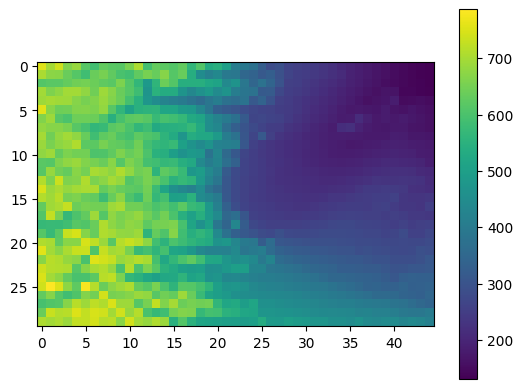

In [66]:
plt.imshow(Y_hat_test_grid[3,:,:])
plt.colorbar()

# Loss

In [147]:
from loss import losses_SparseData
importlib.reload(losses_SparseData)

<module 'loss.losses_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/loss/losses_SparseData.py'>

In [137]:
batch_s = 5
x_batch = torch.stack([ds[i][0] for i in range(batch_s)], dim = 0)
z_batch = torch.stack([ds[i][1] for i in range(batch_s)], dim = 0)
w0_batch = torch.stack([ds[0][2][0] for i in range(batch_s)], dim = 0)
w1_batch = torch.stack([ds[0][2][1] for i in range(batch_s)], dim = 0)
w_batch = [w0_batch, w1_batch]
true_batch = torch.stack([ds[i][-3] for i in range(batch_s)], dim = 0)
xmask_batch = torch.stack([ds[i][-2] for i in range(batch_s)], dim = 0)
ymask_batch = torch.stack([ds[i][-1] for i in range(batch_s)], dim = 0)

In [138]:
model.train()
out_batch = model(x_batch,
                  z_batch,
                  w_batch,
                  xmask_batch,
                       teacher_forcing = True)

In [139]:
norm_factor = [torch.tensor(ds.norm_factors["target_means"]).to(out_batch.device).to(torch.float32),
            torch.tensor(ds.norm_factors["target_stds"]).to(out_batch.device).to(torch.float32)
            ]

In [87]:
out_batch.shape

torch.Size([5, 26, 28])

In [92]:
true_batch.shape

torch.Size([5, 26, 28])

In [155]:
losses_SparseData.loss_masked_h2(out_batch, true_batch, ymask_batch,
            norm_factor)

tensor([[[ 90.5781,  92.5830, 174.8781,  ...,  29.5957,  22.5359,  22.7983],
         [-64.9565, 140.8301, 129.6301,  ..., 140.9766, -96.3849, -89.1852],
         [365.5546, 294.0675, 331.7056,  ..., 175.5725, -87.6100, -76.2506],
         ...,
         [132.6866, 142.8001, 102.6010,  ..., 179.1476, 217.8306, 159.3986],
         [144.0751, 129.7386, 119.3159,  ..., 178.4463, 214.8107, 164.2427],
         [ 94.8056, 176.8314, 163.9642,  ..., 208.4325, 158.4632, 236.5394]],

        [[606.7235, 489.5417, 328.0421,  ..., 177.7885, 223.4379, 154.7892],
         [406.4716, 359.2103, 241.4683,  ..., 133.3777,  28.8863,  31.6063],
         [681.2541, 538.9100, 276.3175,  ...,   3.5021, 166.3419, 149.5751],
         ...,
         [233.0011, 172.5778, 160.3578,  ..., 268.0643, 193.9412, 220.2015],
         [261.3091, 267.8188, 282.5597,  ..., 237.8039, 175.3546, 191.8213],
         [260.9424, 256.3831, 264.4753,  ..., 270.7410, 223.3766, 209.6097]],

        [[405.7957, 393.7622, 336.9928,  ...

tensor(453407.5312, grad_fn=<DivBackward0>)

In [150]:
h2_denorm = losses_SparseData.point_h2((out_batch* norm_factor[1]) + norm_factor[0],
         (true_batch* norm_factor[1]) + norm_factor[0],
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [151]:
h2_norm = losses_SparseData.point_h2(out_batch,
         true_batch,
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [156]:
Y_tstep_avail_mask = (torch.sum(ymask_batch, dim = 1) > 1)
Y_tstep_avail_mask.shape

torch.Size([5, 28])

In [157]:
torch.sum(h2_denorm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(453407.5312, grad_fn=<DivBackward0>)

In [158]:
torch.sum(h2_norm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(1748253.1250, grad_fn=<DivBackward0>)